Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

In [21]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
#else:
    #DATA_PATH = '../data/'

# Module Project: Logistic Regression

Do you like burritos? 🌯 You're in luck then, because in this project you'll create a model to predict whether a burrito is `'Great'`.

The dataset for this assignment comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast. 

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function .
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build `model_logr` using a pipeline that includes three transfomers and `LogisticRegression` predictor. Train model on `X_train` and `X_test`.
- **Task 7:** Calculate the training and test accuracy score for your model.
- **Task 8:** Create a horizontal bar chart showing the 10 most influencial features for your  model. 
- **Task 9:** Demonstrate and explain the differences between `model_lr.predict()` and `model_lr.predict_proba()`.

**Note** 

You should limit yourself to the following libraries:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [22]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from category_encoders import OneHotEncoder

def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'],
                     index_col='Date')
    # Drop unrated burritos
    df.dropna(subset=['overall'], inplace=True)
    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale
    df['Great'] = (df['overall'] >= 4).astype(int)
    # Drop high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Address', 'URL', 'Neighborhood'])
    cutoff = 10
    drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
    #Burrito categories
    df['Burrito'] = df['Burrito'].str.lower()

    california = df['Burrito'].str.contains('california')
    asada = df['Burrito'].str.contains('asada')
    surf = df['Burrito'].str.contains('surf')
    carnitas = df['Burrito'].str.contains('carnitas')

    df.loc[california, 'Burrito'] = 'California'
    df.loc[asada, 'Burrito'] = 'Asada'
    df.loc[surf, 'Burrito'] = 'Surf & Turf'
    df.loc[carnitas, 'Burrito'] = 'Carnitas'
    df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'
    # Drop columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall'])
    df = df.drop(columns=drop_cols)
    # Categorical Variables, change uppercase to lowercase
    for col in df.select_dtypes('object').columns:
      df[col] = df[col].str.lower()
    # Nan to 0
    df = df.fillna(0)
    #x to 1
    df =  df.replace('x', 1) 
    
    return df
filepath = DATA_PATH + 'burritos/burritos.csv'

**Task 1:** Use the above `wrangle` function to import the `burritos.csv` file into a DataFrame named `df`.

In [23]:
filepath = (DATA_PATH + 'burritos/burritos.csv')
df = wrangle(filepath)

During your exploratory data analysis, note that there are several columns whose data type is `object` but that seem to be a binary encoding. For example, `df['Beef'].head()` returns:

```
0      x
1      x
2    NaN
3      x
4      x
Name: Beef, dtype: object
```

**Task 2:** Change the `wrangle` function so that these columns are properly encoded as `0` and `1`s. Be sure your code handles upper- and lowercase `X`s, and `NaN`s.

In [24]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

In [25]:
df.head()

,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,3.5,4.2,0,6.49,3.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2016-01-24,3.5,3.3,0,5.45,3.5,0.0,0.0,0.0,0.0,0.0,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2016-01-24,0.0,0.0,0,4.85,1.5,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2016-01-24,0.0,0.0,0,5.25,2.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2016-01-27,4.0,3.8,1,6.59,4.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,1


In [26]:
df

,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,3.5,4.2,0,6.49,3.0,0.0,0.0,0.0,0.0,0.00,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2016-01-24,3.5,3.3,0,5.45,3.5,0.0,0.0,0.0,0.0,0.00,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2016-01-24,0.0,0.0,0,4.85,1.5,0.0,0.0,0.0,0.0,0.00,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2016-01-24,0.0,0.0,0,5.25,2.0,0.0,0.0,0.0,0.0,0.00,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2016-01-27,4.0,3.8,1,6.59,4.0,0.0,0.0,0.0,0.0,0.00,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,0.0,0.0,0,6.00,1.0,0.0,0.0,17.0,20.5,0.57,5.0,4.0,3.5,0.0,4.0,4.0,2.0,2.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0
2019-08-27,0.0,0.0,0,6.00,4.0,0.0,0.0,19.0,26.0,1.02,4.0,5.0,0.0,3.5,4.0,4.0,5.0,4.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,1
2019-08-27,0.0,0.0,0,7.90,3.0,0.0,0.0,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0


In [27]:
df.shape

(421, 57)

In [28]:
df.info

<bound method DataFrame.info of             Yelp  Google Chips  Cost  ...  Avocado  Corn  Zucchini  Great
Date                                  ...                                
2016-01-18   3.5     4.2     0  6.49  ...        0     0         0      0
2016-01-24   3.5     3.3     0  5.45  ...        0     0         0      0
2016-01-24   0.0     0.0     0  4.85  ...        0     0         0      0
2016-01-24   0.0     0.0     0  5.25  ...        0     0         0      0
2016-01-27   4.0     3.8     1  6.59  ...        0     0         0      1
...          ...     ...   ...   ...  ...      ...   ...       ...    ...
2019-08-27   0.0     0.0     0  6.00  ...        0     0         0      0
2019-08-27   0.0     0.0     0  6.00  ...        0     0         0      1
2019-08-27   0.0     0.0     0  7.90  ...        0     0         0      0
2019-08-27   0.0     0.0     0  7.90  ...        0     0         0      1
2019-08-27   0.0     0.0     0  5.50  ...        0     0         0      1

[421 

If you explore the `'Burrito'` column of `df`, you'll notice that it's a high-cardinality categorical feature. You'll also notice that there's a lot of overlap between the categories. 

**Stretch Goal:** Change the `wrangle` function above so that it engineers four new features: `'california'`, `'asada'`, `'surf'`, and `'carnitas'`. Each row should have a `1` or `0` based on the text information in the `'Burrito'` column. For example, here's how the first 5 rows of the dataset would look.

| **Burrito** | **california** | **asada** | **surf** | **carnitas** |
| :---------- | :------------: | :-------: | :------: | :----------: |
| California  |       1        |     0     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |
|  Carnitas   |       0        |     0     |    0     |      1       |
| Carne asada |       0        |     1     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |

**Note:** Be sure to also drop the `'Burrito'` once you've engineered your new features.

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'Great'`.

In [29]:
target = 'Great'
y = df[target]
X = df.drop(columns=target)

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from 2016 through 2017. 
- Your test set should include data from 2018 and later.

In [30]:
len(X)

421

In [31]:
#might need to specify the first 2018 date featured in the dataset if this doesn't run
#cutoff = '2018-01-01'
#mask = X.index < cutoff

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=  , )

#First splitting to train and test
#X_train, X_test, y_train, y_test 
    #= train_test_split(X, y, test_size=0.2, random_state=1)
#Second splitting to train again into validation and train
 #X_train, X_val, y_train, y_val 
    #= train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#This is randomized. 0.2 is for 20%. Setting aside some of my data for the validation
#X_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=72)

cutoff_1 = '2017-01-01'
mask_1 = df.index < cutoff_1
cutoff_2 = '2018-01-01'
mask_2 = (df.index < cutoff_2) & (df.index >= cutoff_1)
mask_3 = df.index > cutoff_2

X_train, y_train = X.loc[mask_1], y.loc[mask_1]
X_val, y_val = X.loc[mask_2], y.loc[mask_2]

X_test, y_test = X.loc[mask_3], y.loc[mask_3]


# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents. 

In [32]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5906040268456376


In [33]:
y_pred = [y_train.mean()] * len(y_train)

baseline_mae = mean_absolute_error(y_train, y_pred)

# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_logr`, and fit it to your training data. Your pipeline should include:

- a `OneHotEncoder` transformer for categorical features, 
- a `SimpleImputer` transformer to deal with missing values, 
- a [`StandarScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transfomer (which often improves performance in a logistic regression model), and 
- a `LogisticRegression` predictor.

In [34]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(C=0.008)
)
     
model_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Chips'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.008, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', ran

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

In [35]:
training_acc = model_lr.score(X_train, y_train)
test_acc = model_lr.score(X_val, y_val)

print('Training MAE:', training_acc)
print('Test MAE:', test_acc)

Training MAE: 0.87248322147651
Test MAE: 0.8705882352941177


# V. Communicate Results

**Task 8:** Create a horizontal barchart that plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

**Note:** Since you created your model using a `Pipeline`, you'll need to use the [`named_steps`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) attribute to access the coefficients in your `LogisticRegression` predictor. Be sure to look at the shape of the coefficients array before you combine it with the feature names.

In [36]:
type(model_lr.named_steps['logisticregression'])

sklearn.linear_model._logistic.LogisticRegression

In [37]:
#Check attributes for ohe
dir(model_lr.named_steps['onehotencoder'])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dim',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 'category_mapping',
 'cols',
 'drop_cols',
 'drop_invariant',
 'feature_names',
 'fit',
 'fit_transform',
 'generate_mapping',
 'get_dummies',
 'get_feature_names',
 'get_params',
 'handle_missing',
 'handle_unknown',
 'inverse_transform',
 'mapping',
 'ordinal_encoder',
 'return_df',
 'reverse_dummies',
 'set_params',
 'transform',
 'use_cat_names',
 'verbose']

In [44]:
len(model_lr.named_steps['onehotencoder'].get_feature_names())

57

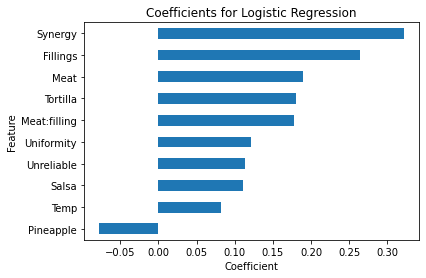

In [38]:
# Create your horizontal barchart here.
coefficients = model_lr.named_steps['logisticregression'].coef_[0]
features = model_lr.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for Logistic Regression');

There is more than one way to generate predictions with `model_lr`. For instance, you can use [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression) or [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.predict_proba).

**Task 9:** Generate predictions for `X_test` using both `predict` and `predict_proba`. Then below, write a summary of the differences in the output for these two methods. You should answer the following questions:

- What data type do `predict` and `predict_proba` output?
- What are the shapes of their different output?
- What numerical values are in the output?
- What do those numerical values represent?

In [39]:
# Write code here to explore the differences between `predict` and `predict_proba`.
y_pred = model_lr.predict(X_test)

#to look at my values, number used inbetween [: ]
y_pred[:10]

#First ten values returned are my predictions

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1])

In [40]:
# Confirming the probability of accuracy  of prediction
y_pred_proba = model_lr.predict_proba(X_test)

y_pred_proba[:10]   
#returns an array with two columns. First column is for 0s, second column is for 1s
#Which column are we interested in concerning the returns of 0s and 1s for Great Burritos?

array([[0.17084772, 0.82915228],
       [0.26576117, 0.73423883],
       [0.55573369, 0.44426631],
       [0.08411062, 0.91588938],
       [0.73125683, 0.26874317],
       [0.6416471 , 0.3583529 ],
       [0.48965993, 0.51034007],
       [0.27183866, 0.72816134],
       [0.6411756 , 0.3588244 ],
       [0.41714872, 0.58285128]])

In [41]:
# To only select the 1 column. The list of values are degrees of certainty for my model believing it's a 1.
y_pred_proba[:10, -1] 

array([0.82915228, 0.73423883, 0.44426631, 0.91588938, 0.26874317,
       0.3583529 , 0.51034007, 0.72816134, 0.3588244 , 0.58285128])

In [42]:
print(y_pred.shape)

(38,)


In [43]:
print(y_pred_proba.shape)

(38, 2)


**Give your written answer here:**

```
The predict function is used not only to gain classes, but probability. While the predict_proba function is used to return the probability of accuracy of prediction.



What data type do predict and predict_proba output?

predict returns integers, while predict_proba returns floats.



What are the shapes of their different output?

predict has a shape of (38,), while predict_proba has a shape of (38, 2).



What numerical values are in the output?

The numerical values returned in the output for both predict and predict_proba are arrays. predict_proba differs by featuring arrays in the form of two columns.



What do those numerical values represent?

The numerical values represent degrees of certainty for our model believing our target to be one of two values, 0 or 1.

```